In [9]:
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import glob as gb

%matplotlib inline

In [10]:
from scipy.optimize import curve_fit

def mono_exp_decay(t, a, tau, c):
    """ Mono-exponential decay function. t is the time."""
    return a * np.exp(-t / tau) + c


def fit_decay(t, y):
    """ Function to fit the data, y, to the mono-exponential decay."""
    # Guess initial fitting parameters
    a_guess = max(y) - min(y)

    y_norm = y - min(y)
    y_norm = y_norm / max(y_norm)
    t_loc = np.where(y_norm <= 1/np.e)
    tau_guess = t[t_loc[0][0]]

    c_guess = min(y)
    # Fit decay
    popt, pcov = curve_fit(mono_exp_decay, t, y, p0=(a_guess, tau_guess, c_guess))
    return popt

In [11]:
# Get list of folders
folders = gb.glob("Data/raw/*")
folders

['Data/raw\\1464107734.408206']

In [12]:
df = pd.DataFrame()

# for folder in folders:
for file in gb.glob(folders[0] + '/*.h5'):
#     print(file)
    
    # Load HDF file
    store = pd.HDFStore(file)
    
    df_file = store['log']
    
    # Create time axis in ms
    fs = store['log']['fs'][0]
    samples = store['log']['sample_no'][0]

    x = np.arange(samples) * fs * 1E3
    
    # Load decay data
    y = store['data']
    
    # Calculate lifetime
    popt = fit_decay(x, y)
    tau = popt[1]
    
    # Append lifetime to dataframe
    df_file['tau'] = tau
    
    # Add sweep data to measurement dataframe
    df = df.append(df_file)
    
    # Close hdf5 file
    store.close()
    
# Sort rows by datetime
df = df.set_index('datetime').sort_index()
df = df.reset_index()
df.head()

,datetime,chip,concentration,fs,humidity,medium,sample_no,sweep_no,sweeps,tempC,timeID,tau
0,2016-05-24 17:35:34.524213,T16,NaN,0.0001,28.54,Air,1000,0,1000,25.83,1.464108e+09,10.740927
1,2016-05-24 17:35:34.768227,T16,NaN,0.0001,28.54,Air,1000,1,1000,25.83,1.464108e+09,10.771419
2,2016-05-24 17:35:34.994240,T16,NaN,0.0001,28.54,Air,1000,2,1000,25.83,1.464108e+09,10.751660
3,2016-05-24 17:35:35.131248,T16,NaN,0.0001,28.54,Air,1000,3,1000,25.83,1.464108e+09,10.748474
4,2016-05-24 17:35:35.281256,T16,NaN,0.0001,28.54,Air,1000,4,1000,25.83,1.464108e+09,10.744047


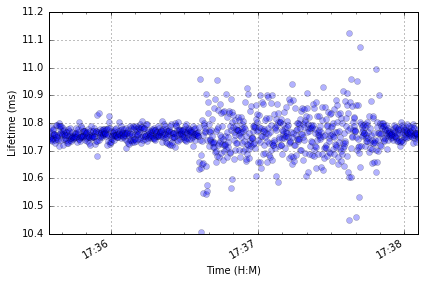

In [24]:
fig, ax = plt.subplots()
ax.plot(df['datetime'], df['tau'], 'o', alpha=0.3)
# ax.plot(df['datetime'], df['tempC'], '-')

# format the ticks
ax.xaxis.set_major_locator(mdates.MinuteLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_minor_locator(mdates.SecondLocator(bysecond=np.arange(0, 60, 10)))

ax.grid(True)
fig.autofmt_xdate()

plt.xlabel('Time (H:M)')
plt.ylabel('Lifetime (ms)')
plt.tight_layout()

# plt.savefig('long.png', dpi=1000)

In [97]:
df.to_csv(folders[0] + '/analysis.csv')

array([ 0, 10, 20, 30, 40, 50])